In [1]:
import numpy as np
import pandas as pd
import time
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Load your dataset
data = pd.read_csv('data/train_tfidf_features.csv')

# Exclude the first column and use the second column as the label
X = data.drop(['label', 'id'], axis=1).values  # Convert to NumPy array
y = data['label'].values  # Convert to NumPy array

# List of random seeds
random_seeds = [42, 52, 62]

# List of boosting algorithms and weak learners
boosting_algorithms = {
    'LightGBM GBDT': LGBMClassifier(boosting_type='gbdt'),
    'LightGBM DART': LGBMClassifier(boosting_type='dart'),
    'LightGBM GOSS': LGBMClassifier(boosting_type='goss')
}

weak_learners = {
    'Decision Stump': DecisionTreeClassifier(max_depth=1),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Gaussian Naive Bayes': GaussianNB()
}

# Initialize dictionaries to store F1 scores and times for each algorithm/learner
boosting_results = {name: {'f1_scores': [], 'times': []} for name in boosting_algorithms}
weak_learner_results = {name: {'f1_scores': [], 'times': []} for name in weak_learners}

def evaluate_boosting(name, model, seed):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Initialize the model
    model.set_params(random_state=seed)
    
    # Measure the start time
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Measure the end time
    end_time = time.time()
    
    # Calculate the time taken
    elapsed_time = end_time - start_time
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the macro F1 score on the test set
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Return the F1 score and time taken
    return name, seed, f1, elapsed_time

def evaluate_learner(name, base_estimator, seed):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Initialize the AdaBoost classifier
    adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=10, learning_rate=1.0, random_state=seed)
    
    # Measure the start time
    start_time = time.time()
    
    # Train the classifier
    adaboost.fit(X_train, y_train)
    
    # Measure the end time
    end_time = time.time()
    
    # Calculate the time taken
    elapsed_time = end_time - start_time
    
    # Predict on the test set
    y_pred = adaboost.predict(X_test)
    
    # Calculate the macro F1 score on the test set
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Return the F1 score and time taken
    return name, seed, f1, elapsed_time

# Use Parallel and delayed to parallelize the evaluation
results_boosting = Parallel(n_jobs=-1)(delayed(evaluate_boosting)(name, model, seed)
                                       for name, model in boosting_algorithms.items()
                                       for seed in random_seeds)

results_weak_learners = Parallel(n_jobs=-1)(delayed(evaluate_learner)(name, base_estimator, seed)
                                            for name, base_estimator in weak_learners.items()
                                            for seed in random_seeds)

# Process results for boosting algorithms
for name, seed, f1, elapsed_time in results_boosting:
    boosting_results[name]['f1_scores'].append(f1)
    boosting_results[name]['times'].append(elapsed_time)

# Process results for weak learners
for name, seed, f1, elapsed_time in results_weak_learners:
    weak_learner_results[name]['f1_scores'].append(f1)
    weak_learner_results[name]['times'].append(elapsed_time)

# Calculate the mean and standard deviation of F1 scores and times for each algorithm/learner
boosting_means_f1 = {name: np.mean(boosting_results[name]['f1_scores']) for name in boosting_algorithms}
boosting_stds_f1 = {name: np.std(boosting_results[name]['f1_scores']) for name in boosting_algorithms}
boosting_means_time = {name: np.mean(boosting_results[name]['times']) for name in boosting_algorithms}
boosting_stds_time = {name: np.std(boosting_results[name]['times']) for name in boosting_algorithms}

learner_means_f1 = {name: np.mean(weak_learner_results[name]['f1_scores']) for name in weak_learners}
learner_stds_f1 = {name: np.std(weak_learner_results[name]['f1_scores']) for name in weak_learners}
learner_means_time = {name: np.mean(weak_learner_results[name]['times']) for name in weak_learners}
learner_stds_time = {name: np.std(weak_learner_results[name]['times']) for name in weak_learners}

# Combine the results for plotting
all_names = list(boosting_means_f1.keys()) + list(learner_means_f1.keys())
all_means_f1 = list(boosting_means_f1.values()) + list(learner_means_f1.values())
all_stds_f1 = list(boosting_stds_f1.values()) + list(learner_stds_f1.values())
all_means_time = list(boosting_means_time.values()) + list(learner_means_time.values())
all_stds_time = list(boosting_stds_time.values()) + list(learner_stds_time.values())

# Create a dual dot plot
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot F1 scores
color = 'tab:blue'
ax1.set_xlabel('Algorithm / Weak Learner')
ax1.set_ylabel('Mean Macro F1 Score', color=color)
ax1.errorbar(all_names, all_means_f1, yerr=all_stds_f1, fmt='o', capsize=5, color=color, label='Mean F1 Score')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot times
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mean Time Taken (seconds)', color=color)
ax2.errorbar(all_names, all_means_time, yerr=all_stds_time, fmt='o', capsize=5, color=color, label='Mean Time Taken')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and grid
plt.title('Mean Macro F1 Score and Mean Time Taken vs. Algorithm with Error Bars')
ax1.grid(True)
fig.tight_layout()
plt.xticks(rotation=45)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# Print the mean and standard deviation of F1 scores and times for each algorithm/learner
for name in all_names:
    if name in boosting_means_f1:
        print(f"Boosting Algorithm: {name}, Mean F1 Score: {boosting_means_f1[name]:.2f}, Std: {boosting_stds_f1[name]:.2f}")
        print(f"Boosting Algorithm: {name}, Mean Time Taken: {boosting_means_time[name]:.2f} seconds, Std: {boosting_stds_time[name]:.2f}")
    else:
        print(f"Weak Learner: {name}, Mean F1 Score: {learner_means_f1[name]:.2f}, Std: {learner_stds_f1[name]:.2f}")
        print(f"Weak Learner: {name}, Mean Time Taken: {learner_means_time[name]:.2f} seconds, Std: {learner_stds_time[name]:.2f}")

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 5221, number of negative: 8526
[LightGBM] [Info] Number of positive: 5267, number of negative: 8480
[LightGBM] [Info] Number of positive: 5217, number of negative: 8530
[LightGBM] [Info] Number of positive: 5221, number of negative: 8526
[LightGBM] [Info] Number of positive: 5217, number of negative: 8530
[LightGBM] [Info

/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anacond

KeyboardInterrupt: 

X_train shape: (13747, 5000)
X_test shape: (3437, 5000)
y_train shape: (13747,)
y_test shape: (3437,)
Evaluating num_leaves with value 15...
[LightGBM] [Info] Number of positive: 4162, number of negative: 6835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18960
[LightGBM] [Info] Number of data points in the train set: 10997, number of used features: 816
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378467 -> initscore=-0.496061
[LightGBM] [Info] Start training from score -0.496061
[LightGBM] [Info] Number of positive: 4227, number of negative: 6770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

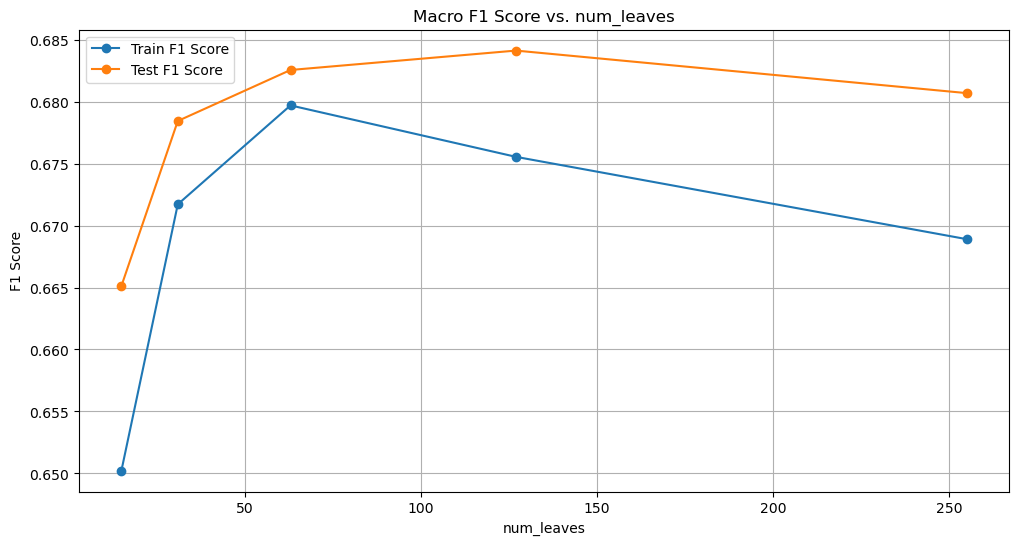

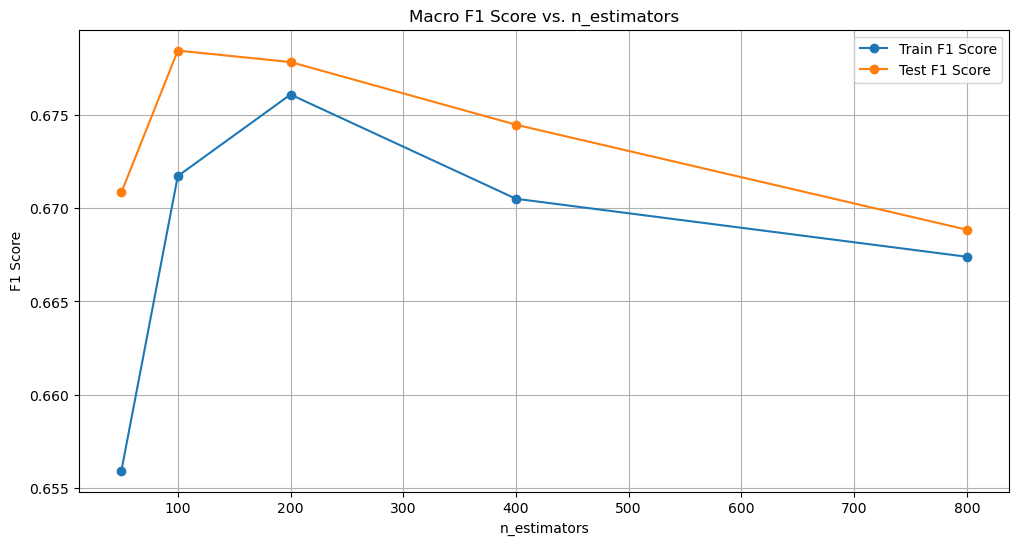

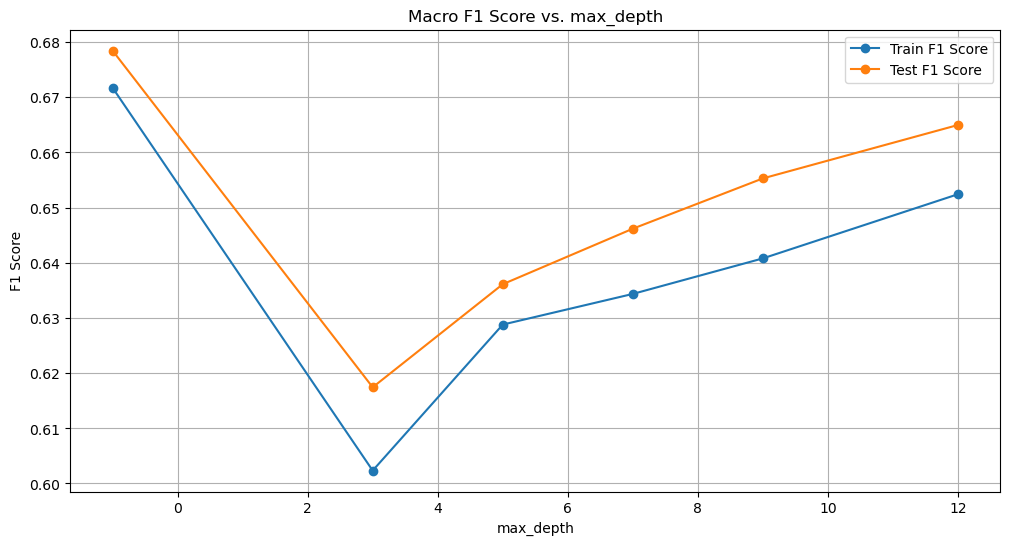

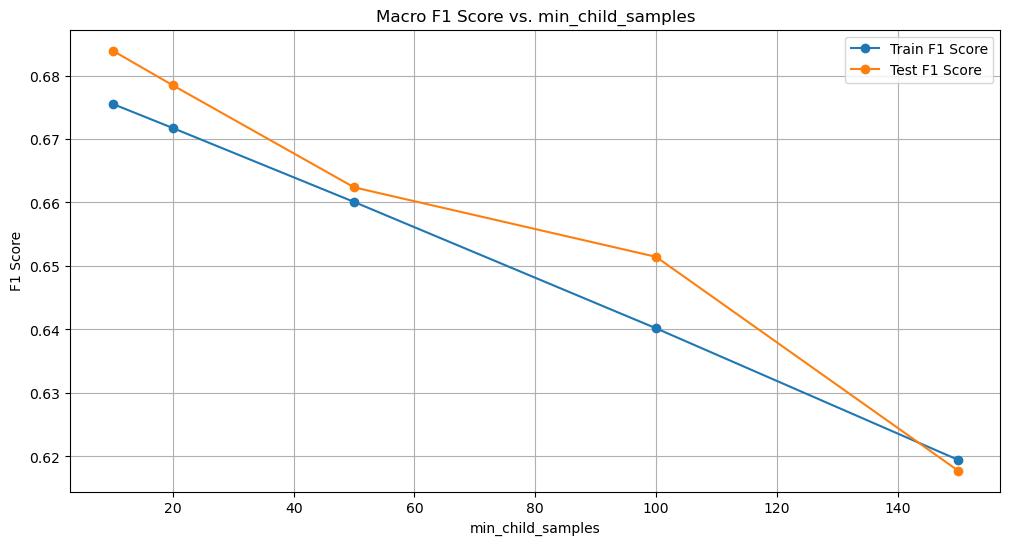

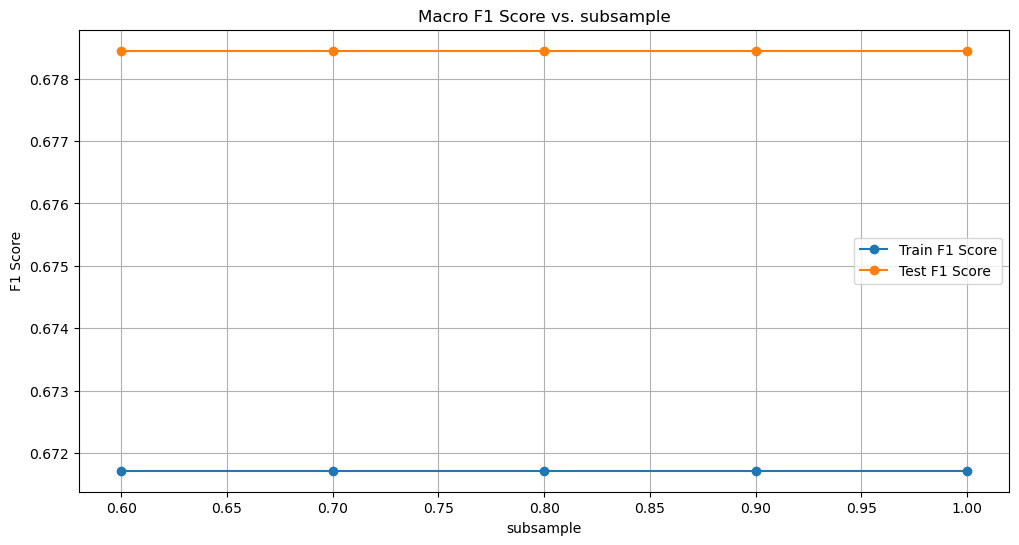

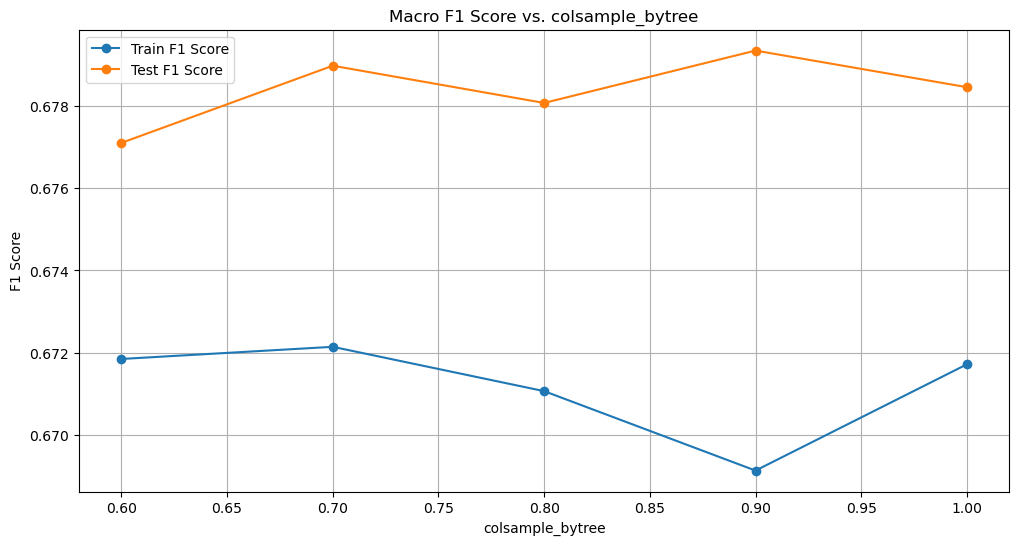

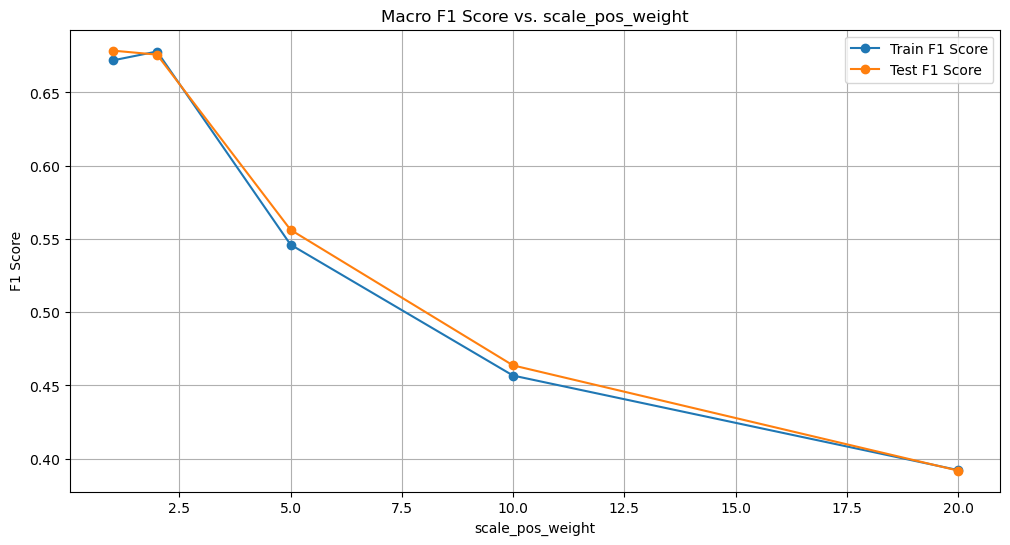

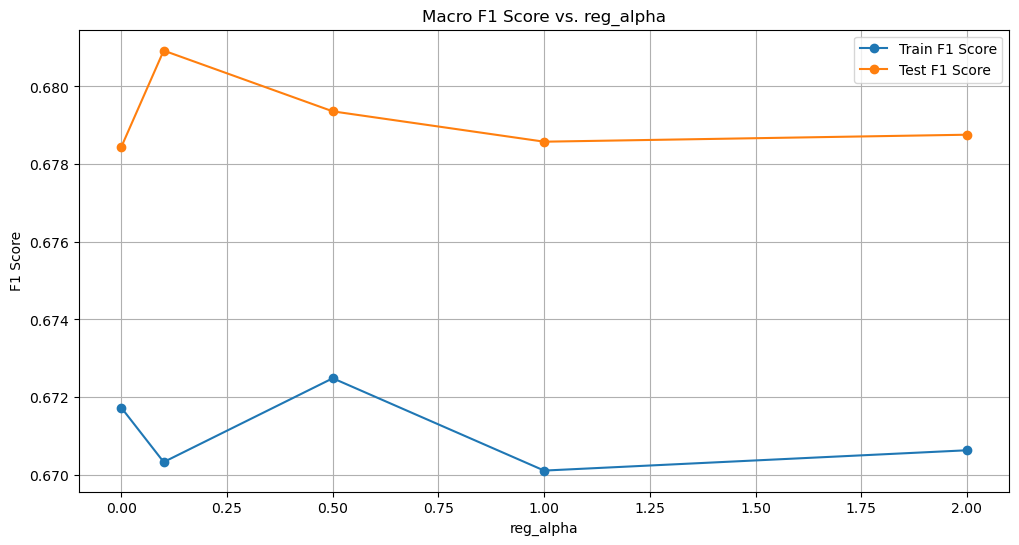

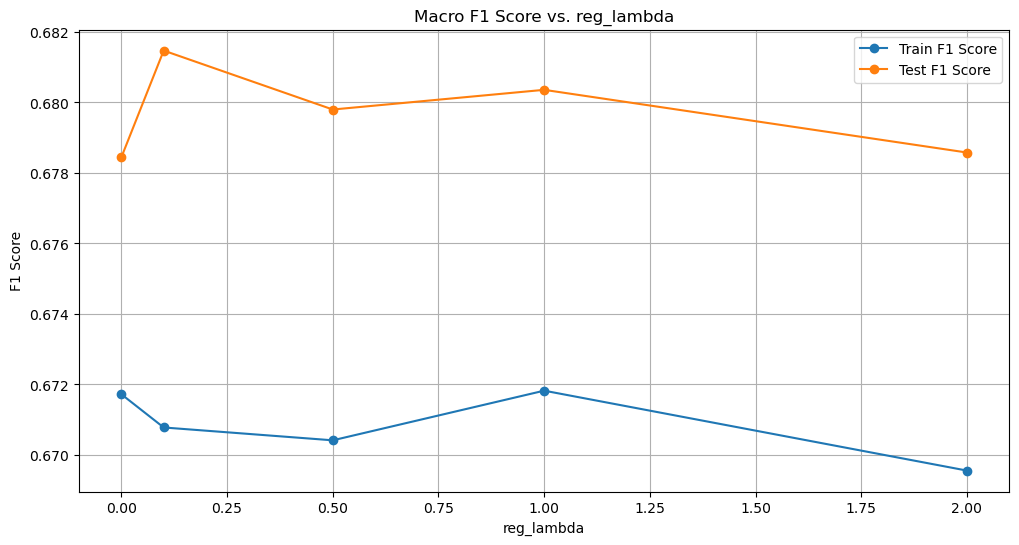

Hyperparameter: num_leaves
Values: [15, 31, 63, 127, 255]
Train F1 Scores: [0.6502236936957957, 0.6717188807651581, 0.6797037843193813, 0.6755501946752869, 0.6689031652454837]
Test F1 Scores: [0.6651298935979113, 0.6784452642849037, 0.6825623094013805, 0.6841284766712941, 0.6806938081500346]

Hyperparameter: n_estimators
Values: [50, 100, 200, 400, 800]
Train F1 Scores: [0.6559377884969366, 0.6717188807651581, 0.6760896791754094, 0.6705036166651995, 0.667395731647835]
Test F1 Scores: [0.6708462977784304, 0.6784452642849037, 0.6778310878332503, 0.6744728805525428, 0.6688454314511754]

Hyperparameter: max_depth
Values: [-1, 3, 5, 7, 9, 12]
Train F1 Scores: [0.6717188807651581, 0.6023339911689538, 0.6287916018465467, 0.6343489932350396, 0.6407882284684591, 0.6524165272818946]
Test F1 Scores: [0.6784452642849037, 0.6174283291367143, 0.6361076239661425, 0.6461672342723789, 0.655284144587782, 0.664962034258428]

Hyperparameter: min_child_samples
Values: [10, 20, 50, 100, 150]
Train F1 Scores

In [ ]:
import numpy as np
import pandas as pd
import time
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data/train_tfidf_features.csv')

# Exclude the first column and use the second column as the label
X = data.drop(['label', 'id'], axis=1).values
y = data['label'].values

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# List of hyperparameters and their ranges
hyperparameters = {
    'num_leaves': [15, 31, 63, 127, 255],
    'n_estimators': [50, 100, 200, 400, 800],
    'max_depth': [-1, 3, 5, 7, 9, 12],
    'min_child_samples': [10, 20, 50, 100, 150],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 5, 10, 20],
    'reg_alpha': [0, 0.1, 0.5, 1, 2],
    'reg_lambda': [0, 0.1, 0.5, 1, 2]
}

# Initialize a dictionary to store results
results = {param: {'train_f1_scores': [], 'test_f1_scores': []} for param in hyperparameters}

def evaluate_hyperparameter(param_name, param_values):
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    
    for value in param_values:
        print(f"Evaluating {param_name} with value {value}...")
        train_f1_scores = []
        test_f1_scores = []

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            params = {
                'boosting_type': 'gbdt',
                'num_leaves': 31,  # Default
                'n_estimators': 100,  # Default
                'max_depth': -1,  # Default
                'min_child_samples': 20,  # Default
                'subsample': 1.0,  # Default
                'colsample_bytree': 1.0,  # Default
                'scale_pos_weight': 1,  # Default
                'reg_alpha': 0,  # Default
                'reg_lambda': 0,  # Default
                'random_state': 123
            }
            params[param_name] = value
            
            model = LGBMClassifier(**params)
            
            start_time = time.time()
            try:
                model.fit(X_train_fold, y_train_fold)
                y_val_pred = model.predict(X_val_fold)
                y_test_pred = model.predict(X_test)
                
                train_f1_scores.append(f1_score(y_val_fold, y_val_pred, average='macro'))
                test_f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
            except Exception as e:
                print(f"Error while training or predicting with {param_name}={value}: {e}")

        if train_f1_scores and test_f1_scores:
            results[param_name]['train_f1_scores'].append(np.mean(train_f1_scores))
            results[param_name]['test_f1_scores'].append(np.mean(test_f1_scores))
        else:
            print(f"No scores collected for {param_name} with value {value}")

# Evaluate each hyperparameter
for param_name, param_values in hyperparameters.items():
    evaluate_hyperparameter(param_name, param_values)

# Plotting results for each hyperparameter
for param_name in hyperparameters:
    if results[param_name]['train_f1_scores']:
        plt.figure(figsize=(12, 6))
        plt.plot(hyperparameters[param_name], results[param_name]['train_f1_scores'], marker='o', label='Train F1 Score')
        plt.plot(hyperparameters[param_name], results[param_name]['test_f1_scores'], marker='o', label='Test F1 Score')
        plt.xlabel(param_name)
        plt.ylabel('F1 Score')
        plt.title(f'Macro F1 Score vs. {param_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"No results for hyperparameter {param_name}")

# Print results
for param_name in hyperparameters:
    print(f"Hyperparameter: {param_name}")
    print(f"Values: {hyperparameters[param_name]}")
    print(f"Train F1 Scores: {results[param_name]['train_f1_scores']}")
    print(f"Test F1 Scores: {results[param_name]['test_f1_scores']}")
    print()

X_train shape: (13747, 5000)
X_test shape: (3437, 5000)
y_train shape: (13747,)
y_test shape: (3437,)
Evaluating num_leaves with value 31...
[LightGBM] [Info] Number of positive: 4162, number of negative: 6835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23269
[LightGBM] [Info] Number of data points in the train set: 10997, number of used features: 1548
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378467 -> initscore=-0.496061
[LightGBM] [Info] Start training from score -0.496061
[LightGBM] [Info] Number of positive: 4227, number of negative: 6770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Ligh

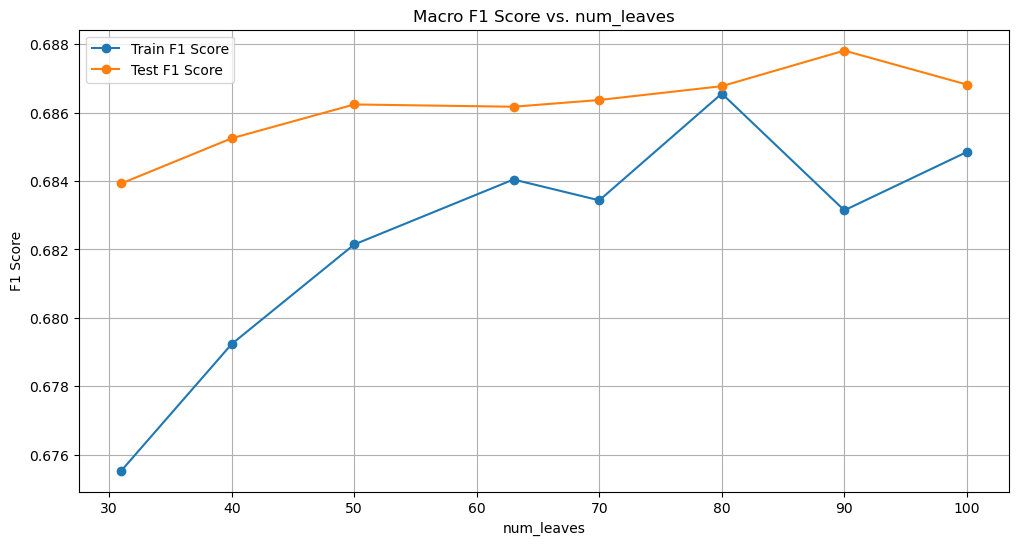

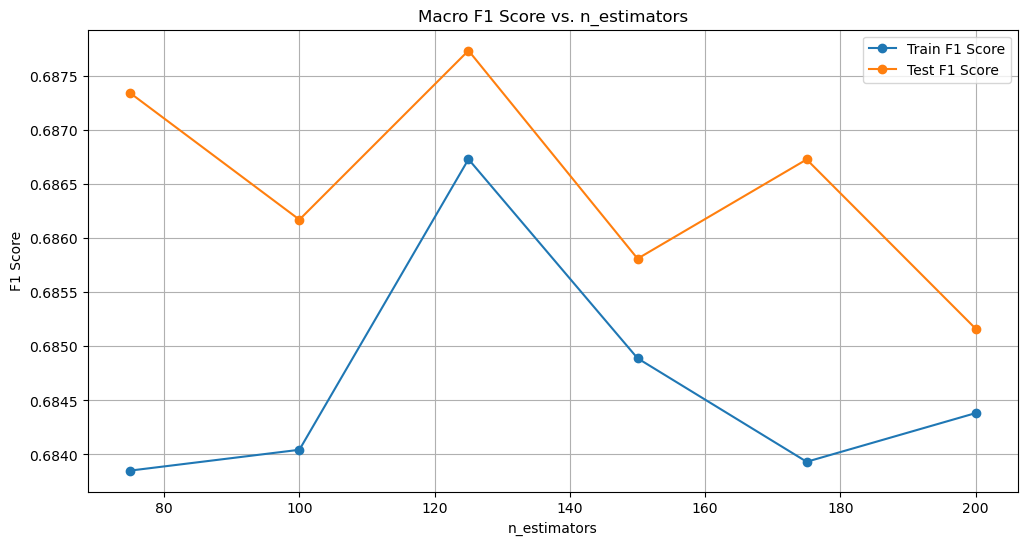

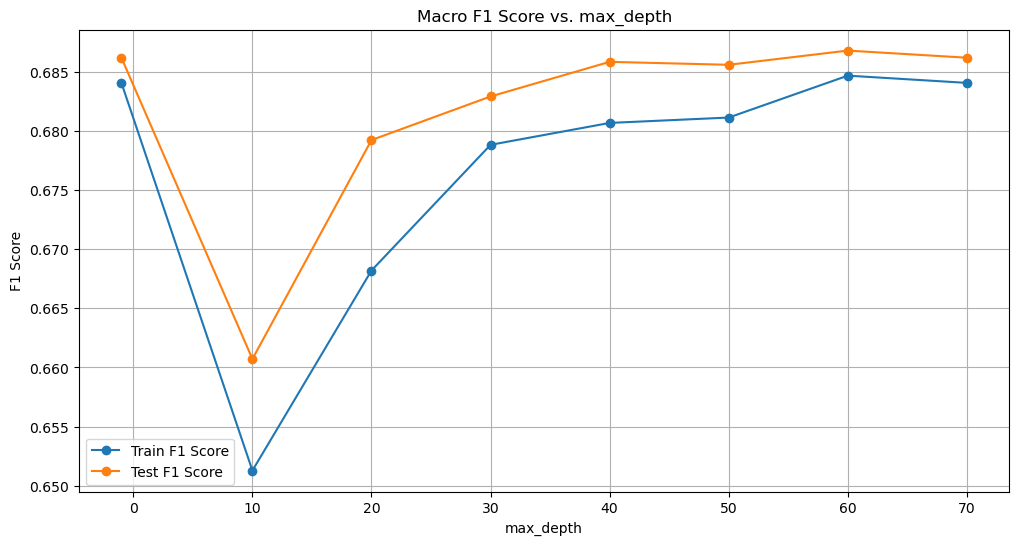

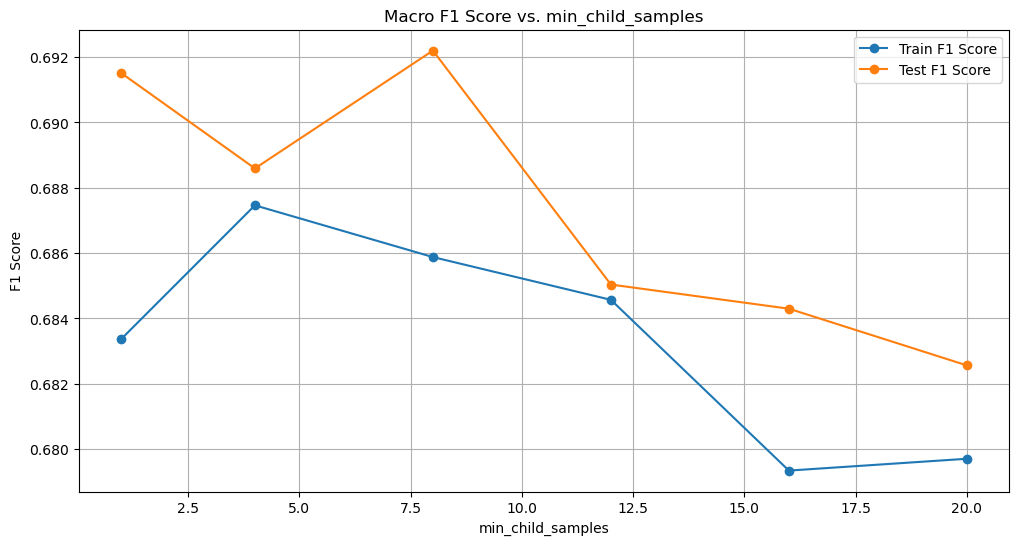

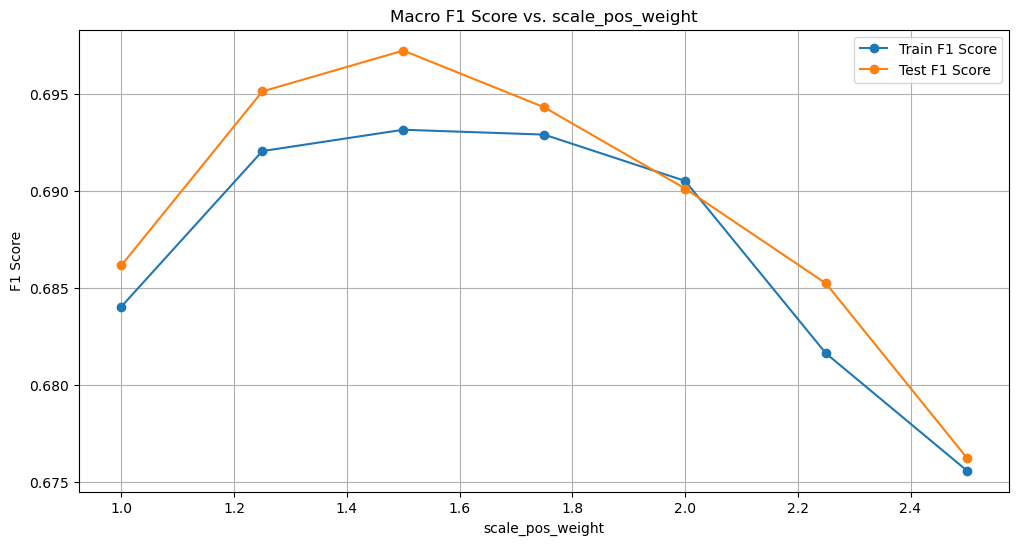

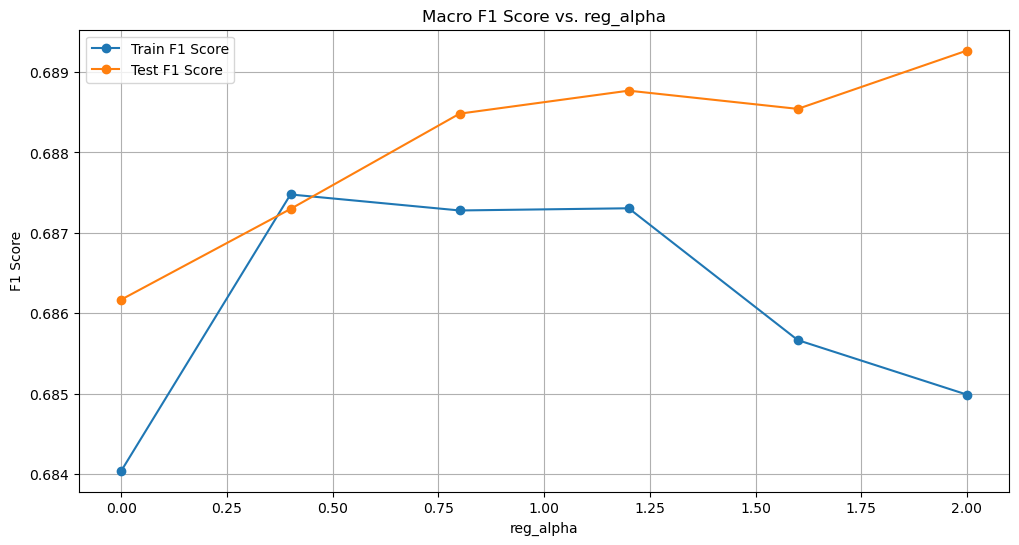

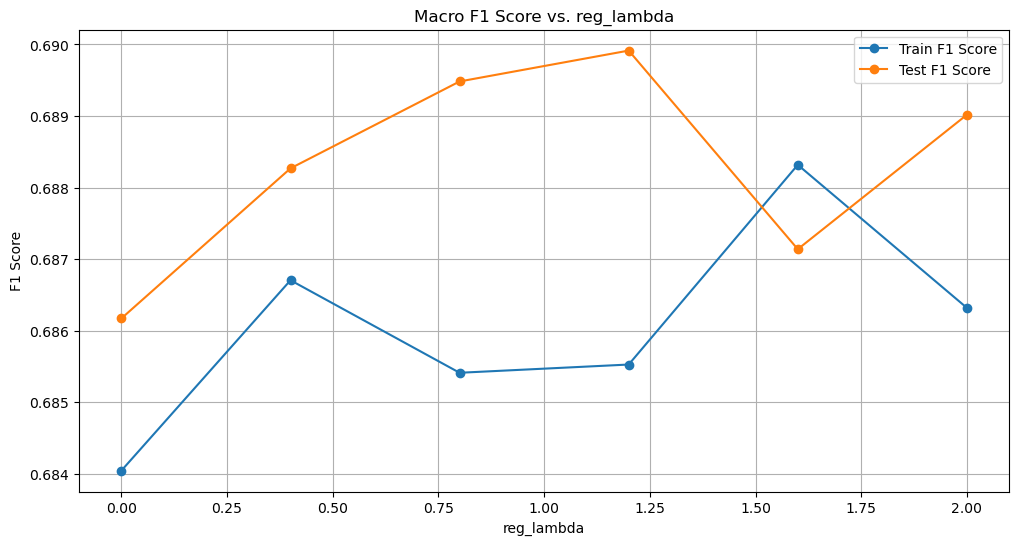

Hyperparameter: num_leaves
Values: [31, 40, 50, 63, 70, 80, 90, 100]
Train F1 Scores: [0.6755330640948038, 0.6792329725844743, 0.6821429332021236, 0.6840426575003485, 0.6834339488237692, 0.6865550279798049, 0.6831415448179169, 0.6848469617164886]
Test F1 Scores: [0.6839279942327297, 0.6852473825199327, 0.6862363452986066, 0.6861702573481756, 0.6863671491507952, 0.6867713933053704, 0.6878116981628809, 0.6868182855001054]

Hyperparameter: n_estimators
Values: [75, 100, 125, 150, 175, 200]
Train F1 Scores: [0.6838503597835928, 0.6840426575003485, 0.6867289651388233, 0.6848885662287022, 0.6839318173175144, 0.6843821574337803]
Test F1 Scores: [0.6873400171300622, 0.6861702573481756, 0.687733378677622, 0.6858095093499779, 0.6867268740404947, 0.6851612484388554]

Hyperparameter: max_depth
Values: [-1, 10, 20, 30, 40, 50, 60, 70]
Train F1 Scores: [0.6840426575003485, 0.6512762550152184, 0.6681853728970181, 0.6788078145227587, 0.6806583046446056, 0.6811130111971384, 0.6846542035351427, 0.684042

In [ ]:
import numpy as np
import pandas as pd
import time
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data/train_tfidf_features.csv')

# Exclude the first column and use the second column as the label
X = data.drop(['label', 'id'], axis=1).values
y = data['label'].values

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# List of hyperparameters and their ranges
hyperparameters = {
    'num_leaves': [31, 40, 50, 63, 70, 80, 90, 100],
    'n_estimators': [75, 100, 125, 150, 175, 200],
    'max_depth': [-1, 10, 20, 30, 40, 50, 60, 70],
    'min_child_samples': [1, 4, 8, 12, 16, 20],
    'scale_pos_weight': [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
    'reg_alpha': [0, 0.4, 0.8, 1.2, 1.6, 2],
    'reg_lambda': [0, 0.4, 0.8, 1.2, 1.6, 2]
}

# Initialize a dictionary to store results
results = {param: {'train_f1_scores': [], 'test_f1_scores': []} for param in hyperparameters}

def evaluate_hyperparameter(param_name, param_values):
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    
    for value in param_values:
        print(f"Evaluating {param_name} with value {value}...")
        train_f1_scores = []
        test_f1_scores = []

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            params = {
                'boosting_type': 'gbdt',
                'num_leaves': 63,  # Default
                'n_estimators': 100,  # Default
                'max_depth': -1,  # Default
                'min_child_samples': 10,  # Default
                'subsample': 1.0,  # Default
                'colsample_bytree': 1.0,  # Default
                'scale_pos_weight': 1,  # Default
                'reg_alpha': 0,  # Default
                'reg_lambda': 0,  # Default
                'random_state': 123
            }
            params[param_name] = value
            
            model = LGBMClassifier(**params)
            
            start_time = time.time()
            try:
                model.fit(X_train_fold, y_train_fold)
                y_val_pred = model.predict(X_val_fold)
                y_test_pred = model.predict(X_test)
                
                train_f1_scores.append(f1_score(y_val_fold, y_val_pred, average='macro'))
                test_f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
            except Exception as e:
                print(f"Error while training or predicting with {param_name}={value}: {e}")

        if train_f1_scores and test_f1_scores:
            results[param_name]['train_f1_scores'].append(np.mean(train_f1_scores))
            results[param_name]['test_f1_scores'].append(np.mean(test_f1_scores))
        else:
            print(f"No scores collected for {param_name} with value {value}")

# Evaluate each hyperparameter
for param_name, param_values in hyperparameters.items():
    evaluate_hyperparameter(param_name, param_values)

# Plotting results for each hyperparameter
for param_name in hyperparameters:
    if results[param_name]['train_f1_scores']:
        plt.figure(figsize=(12, 6))
        plt.plot(hyperparameters[param_name], results[param_name]['train_f1_scores'], marker='o', label='Train F1 Score')
        plt.plot(hyperparameters[param_name], results[param_name]['test_f1_scores'], marker='o', label='Test F1 Score')
        plt.xlabel(param_name)
        plt.ylabel('F1 Score')
        plt.title(f'Macro F1 Score vs. {param_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"No results for hyperparameter {param_name}")

# Print results
for param_name in hyperparameters:
    print(f"Hyperparameter: {param_name}")
    print(f"Values: {hyperparameters[param_name]}")
    print(f"Train F1 Scores: {results[param_name]['train_f1_scores']}")
    print(f"Test F1 Scores: {results[param_name]['test_f1_scores']}")
    print()

X_train shape: (13747, 5000)
X_test shape: (3437, 5000)
y_train shape: (13747,)
y_test shape: (3437,)
Evaluating num_leaves with value 31...
[LightGBM] [Info] Number of positive: 4162, number of negative: 6835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23269
[LightGBM] [Info] Number of data points in the train set: 10997, number of used features: 1548
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378467 -> initscore=-0.496061
[LightGBM] [Info] Start training from score -0.496061
[LightGBM] [Info] Number of positive: 4227, number of negative: 6770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23521
[LightGBM] [Info] Number of data p

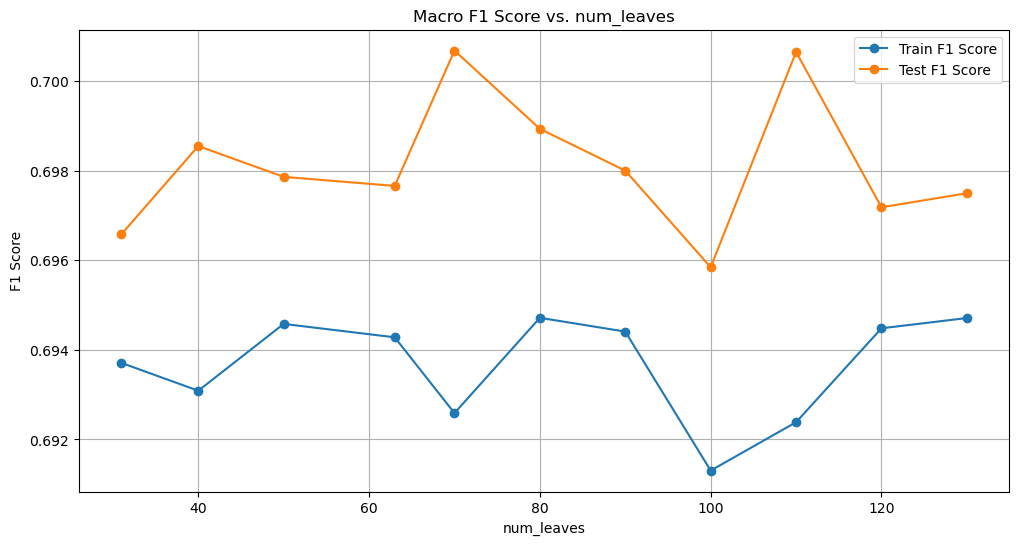

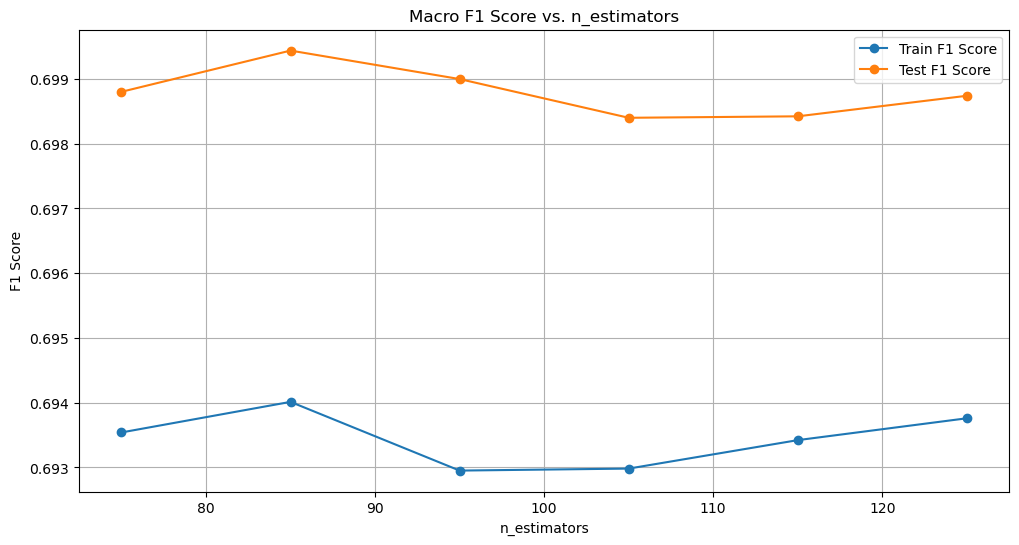

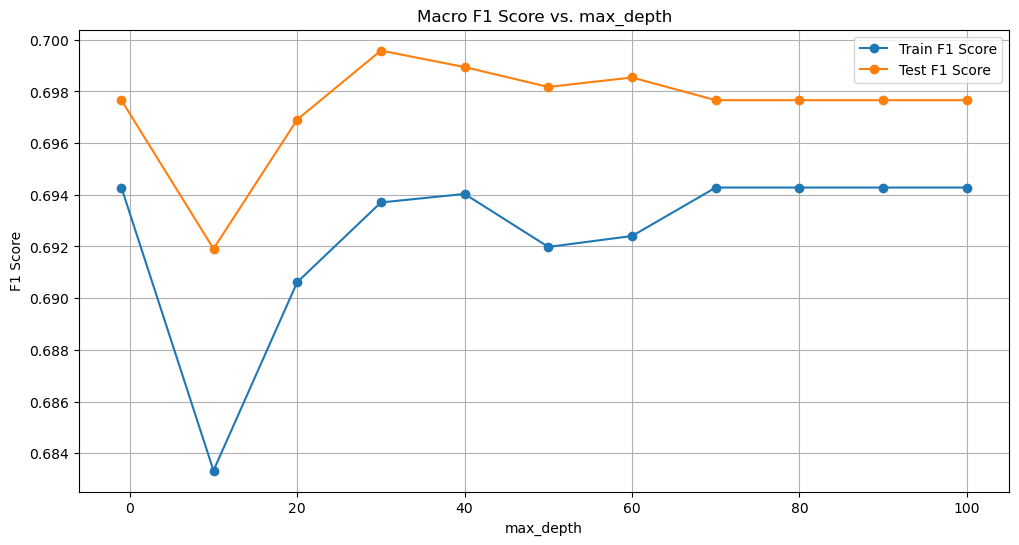

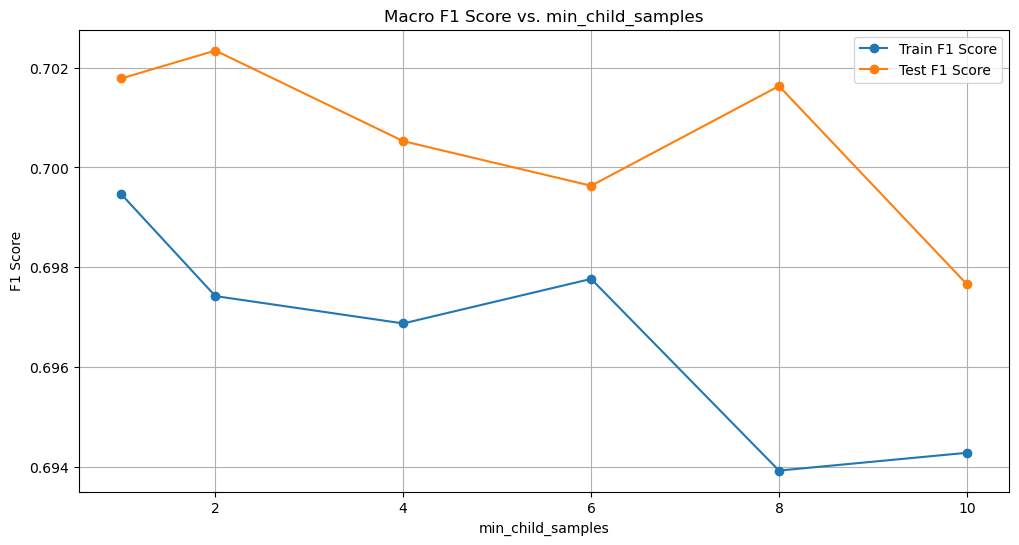

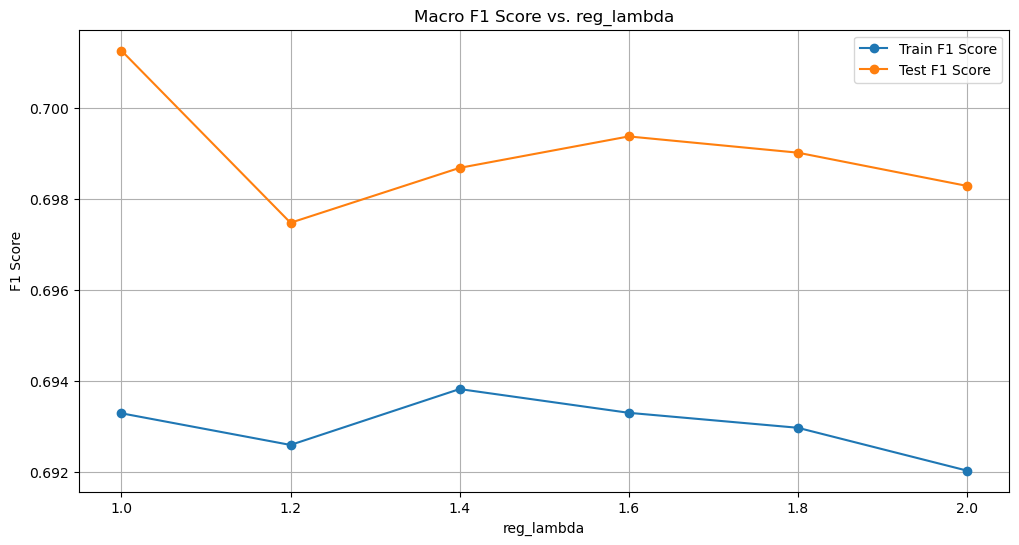

Hyperparameter: num_leaves
Values: [31, 40, 50, 63, 70, 80, 90, 100, 110, 120, 130]
Train F1 Scores: [0.6937072320292481, 0.6930860904586703, 0.6945773539315333, 0.6942782447542125, 0.6925868551707799, 0.6947134452922118, 0.6944057684748834, 0.6913037530640631, 0.6923835633866187, 0.6944793747148479, 0.6947083240076951]
Test F1 Scores: [0.6965791362776923, 0.6985472463833886, 0.6978595294330286, 0.6976573729448537, 0.7006778586893695, 0.6989309440757068, 0.6979975476254237, 0.6958422895651537, 0.7006474687305841, 0.6971805111982998, 0.6974936017419602]

Hyperparameter: n_estimators
Values: [75, 85, 95, 105, 115, 125]
Train F1 Scores: [0.6935389498220705, 0.6940109744549231, 0.6929501820482382, 0.6929809871720553, 0.693420374239443, 0.693757771900599]
Test F1 Scores: [0.6987982664964006, 0.6994348042068009, 0.6989950905174052, 0.6983971770738466, 0.6984197997064173, 0.6987369957304649]

Hyperparameter: max_depth
Values: [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Train F1 Scores: [0.6

In [ ]:
import numpy as np
import pandas as pd
import time
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data/train_tfidf_features.csv')

# Exclude the first column and use the second column as the label
X = data.drop(['label', 'id'], axis=1).values
y = data['label'].values

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# List of hyperparameters and their ranges
hyperparameters = {
    'num_leaves': [31, 40, 50, 63, 70, 80, 90, 100, 110, 120, 130],
    'n_estimators': [75, 85, 95, 105, 115, 125],
    'max_depth': [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_child_samples': [1, 2, 4, 6, 8, 10],
    'reg_lambda': [1, 1.2, 1.4, 1.6, 1.8, 2.0]
}

# Initialize a dictionary to store results
results = {param: {'train_f1_scores': [], 'test_f1_scores': []} for param in hyperparameters}

def evaluate_hyperparameter(param_name, param_values):
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    
    for value in param_values:
        print(f"Evaluating {param_name} with value {value}...")
        train_f1_scores = []
        test_f1_scores = []

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            params = {
                'boosting_type': 'gbdt',
                'num_leaves': 63,  # Default
                'n_estimators': 100,  # Default
                'max_depth': -1,  # Default
                'min_child_samples': 10,  # Default
                'subsample': 1.0,  # Default
                'colsample_bytree': 1.0,  # Default
                'scale_pos_weight': 1.5,  # DONE
                'reg_alpha': 1.2,  # DONE
                'reg_lambda': 0,  # Default
                'random_state': 123
            }
            params[param_name] = value
            
            model = LGBMClassifier(**params)
            
            start_time = time.time()
            try:
                model.fit(X_train_fold, y_train_fold)
                y_val_pred = model.predict(X_val_fold)
                y_test_pred = model.predict(X_test)
                
                train_f1_scores.append(f1_score(y_val_fold, y_val_pred, average='macro'))
                test_f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
            except Exception as e:
                print(f"Error while training or predicting with {param_name}={value}: {e}")

        if train_f1_scores and test_f1_scores:
            results[param_name]['train_f1_scores'].append(np.mean(train_f1_scores))
            results[param_name]['test_f1_scores'].append(np.mean(test_f1_scores))
        else:
            print(f"No scores collected for {param_name} with value {value}")

# Evaluate each hyperparameter
for param_name, param_values in hyperparameters.items():
    evaluate_hyperparameter(param_name, param_values)

# Plotting results for each hyperparameter
for param_name in hyperparameters:
    if results[param_name]['train_f1_scores']:
        plt.figure(figsize=(12, 6))
        plt.plot(hyperparameters[param_name], results[param_name]['train_f1_scores'], marker='o', label='Train F1 Score')
        plt.plot(hyperparameters[param_name], results[param_name]['test_f1_scores'], marker='o', label='Test F1 Score')
        plt.xlabel(param_name)
        plt.ylabel('F1 Score')
        plt.title(f'Macro F1 Score vs. {param_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"No results for hyperparameter {param_name}")

# Print results
for param_name in hyperparameters:
    print(f"Hyperparameter: {param_name}")
    print(f"Values: {hyperparameters[param_name]}")
    print(f"Train F1 Scores: {results[param_name]['train_f1_scores']}")
    print(f"Test F1 Scores: {results[param_name]['test_f1_scores']}")
    print()

X_train shape: (13747, 5000)
X_test shape: (3437, 5000)
y_train shape: (13747,)
y_test shape: (3437,)
Evaluating min_child_samples with value 1...
[LightGBM] [Info] Number of positive: 4162, number of negative: 6835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32638
[LightGBM] [Info] Number of data points in the train set: 10997, number of used features: 4946
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378467 -> initscore=-0.496061
[LightGBM] [Info] Start training from score -0.496061
Trained with min_child_samples=1 in 1.86 seconds
[LightGBM] [Info] Number of positive: 4227, number of negative: 6770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [In

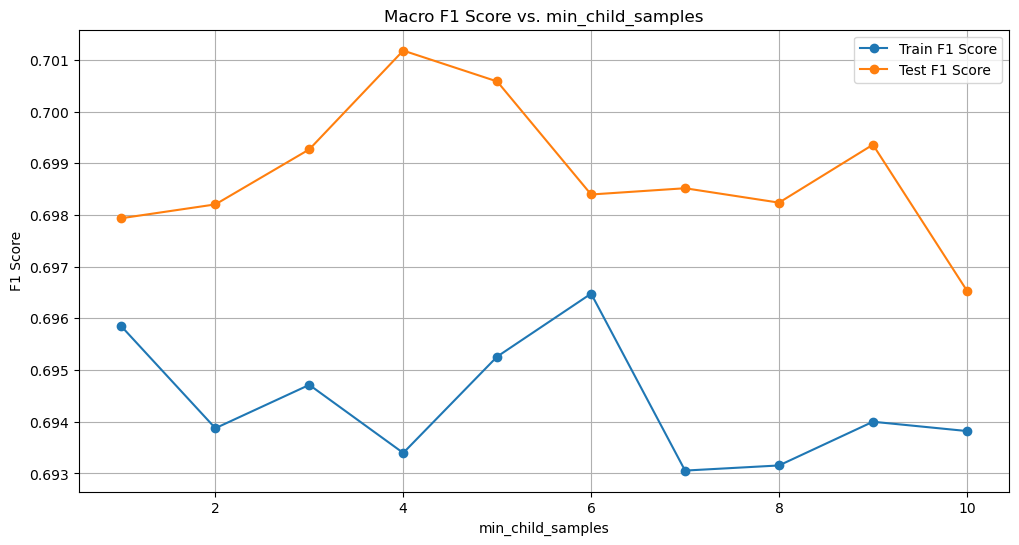

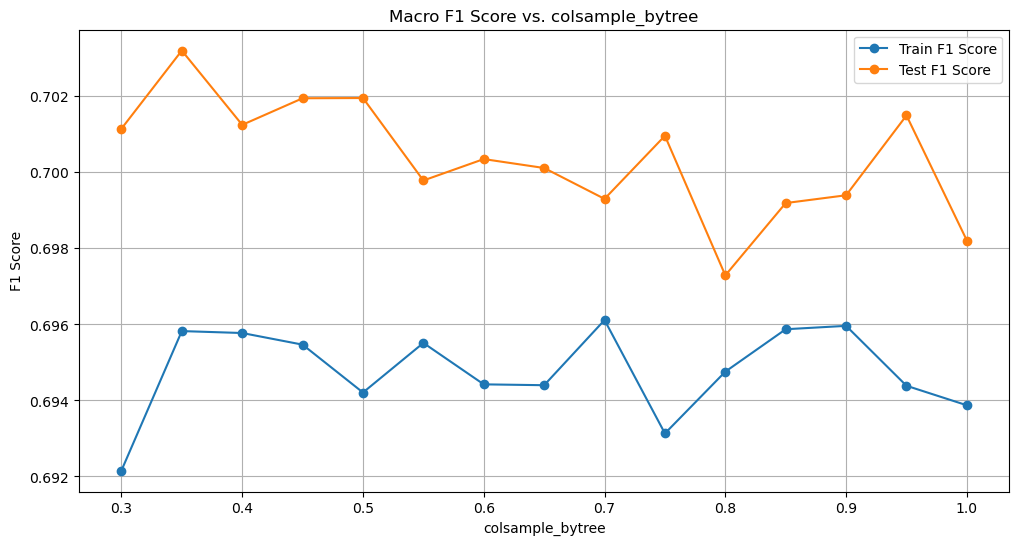

Hyperparameter: min_child_samples
Values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Train F1 Scores: [0.6958422206376452, 0.6938713984047624, 0.694710547565797, 0.6933930567338691, 0.6952576358502741, 0.6964758543452938, 0.6930517793847807, 0.6931509879251507, 0.6939969127367887, 0.6938169410640118]
Test F1 Scores: [0.6979354420812433, 0.6982026833405615, 0.6992678671852002, 0.7011793038318412, 0.7005816436317449, 0.6983945198501432, 0.6985155001172809, 0.6982367262253388, 0.6993583681372458, 0.6965356067090771]

Hyperparameter: colsample_bytree
Values: [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
Train F1 Scores: [0.6921549021404482, 0.695821668158531, 0.695770832839826, 0.6954650938047694, 0.6942065822411798, 0.6955101853605397, 0.6944214449701154, 0.6943990362378253, 0.6961117473714525, 0.6931317146828434, 0.6947549499441675, 0.6958702580637643, 0.6959590920650071, 0.6943841519032934, 0.6938713984047624]
Test F1 Scores: [0.7011408335618828, 0.70319489958141

In [ ]:
import numpy as np
import pandas as pd
import time
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data/train_tfidf_features.csv')

# Exclude the first column and use the second column as the label
X = data.drop(['label', 'id'], axis=1).values
y = data['label'].values

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# List of hyperparameters and their ranges
hyperparameters = {
    'min_child_samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'colsample_bytree': [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
}

# Initialize a dictionary to store results
results = {param: {'train_f1_scores': [], 'test_f1_scores': []} for param in hyperparameters}

def evaluate_hyperparameter(param_name, param_values):
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    
    for value in param_values:
        print(f"Evaluating {param_name} with value {value}...")
        train_f1_scores = []
        test_f1_scores = []

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            params = {
                'boosting_type': 'gbdt',
                'num_leaves': 70,
                'n_estimators': 85,
                'max_depth': 30,
                'min_child_samples': 2,
                'subsample': 1.0,  # Default
                'colsample_bytree': 1.0,  # Default
                'scale_pos_weight': 1.5,
                'reg_alpha': 1.2,
                'reg_lambda': 1,
                'random_state': 123
            }
            params[param_name] = value
            
            model = LGBMClassifier(**params)
            
            start_time = time.time()
            try:
                model.fit(X_train_fold, y_train_fold)
                y_val_pred = model.predict(X_val_fold)
                y_test_pred = model.predict(X_test)
                
                train_f1_scores.append(f1_score(y_val_fold, y_val_pred, average='macro'))
                test_f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
                
                # Check the impact on training
                print(f"Trained with {param_name}={value} in {time.time() - start_time:.2f} seconds")
            except Exception as e:
                print(f"Error while training or predicting with {param_name}={value}: {e}")

        if train_f1_scores and test_f1_scores:
            results[param_name]['train_f1_scores'].append(np.mean(train_f1_scores))
            results[param_name]['test_f1_scores'].append(np.mean(test_f1_scores))
        else:
            print(f"No scores collected for {param_name} with value {value}")

# Evaluate each hyperparameter
for param_name, param_values in hyperparameters.items():
    evaluate_hyperparameter(param_name, param_values)

# Plotting results for each hyperparameter
for param_name in hyperparameters:
    if results[param_name]['train_f1_scores']:
        plt.figure(figsize=(12, 6))
        plt.plot(hyperparameters[param_name], results[param_name]['train_f1_scores'], marker='o', label='Train F1 Score')
        plt.plot(hyperparameters[param_name], results[param_name]['test_f1_scores'], marker='o', label='Test F1 Score')
        plt.xlabel(param_name)
        plt.ylabel('F1 Score')
        plt.title(f'Macro F1 Score vs. {param_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"No results for hyperparameter {param_name}")

# Print results
for param_name in hyperparameters:
    print(f"Hyperparameter: {param_name}")
    print(f"Values: {hyperparameters[param_name]}")
    print(f"Train F1 Scores: {results[param_name]['train_f1_scores']}")
    print(f"Test F1 Scores: {results[param_name]['test_f1_scores']}")
    print()

X_train shape: (13747, 5000)
X_test shape: (3437, 5000)
y_train shape: (13747,)
y_test shape: (3437,)
Evaluating colsample_bytree with value 0.3...
[LightGBM] [Info] Number of positive: 4162, number of negative: 6835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29786
[LightGBM] [Info] Number of data points in the train set: 10997, number of used features: 3520
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378467 -> initscore=-0.496061
[LightGBM] [Info] Start training from score -0.496061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

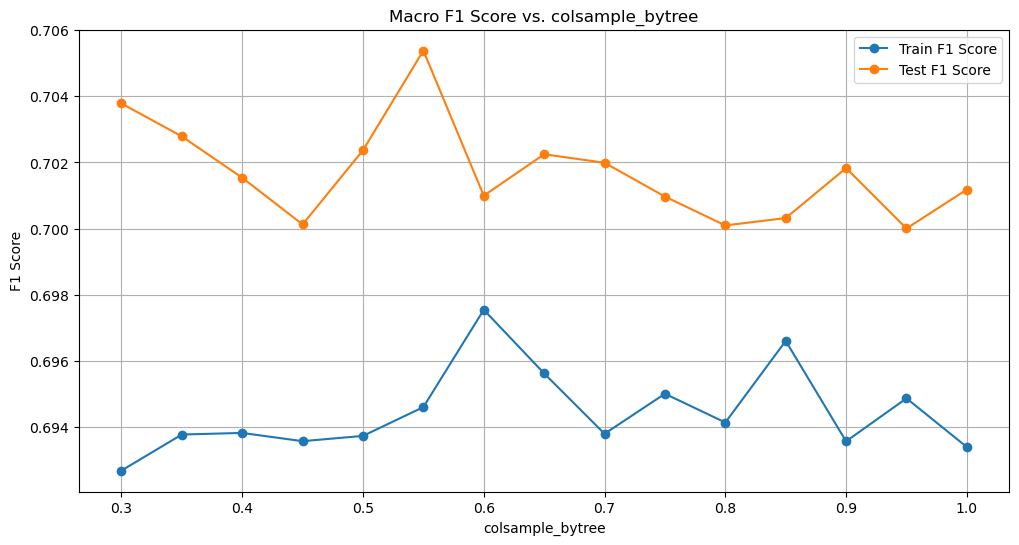

Hyperparameter: colsample_bytree
Values: [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
Train F1 Scores: [0.6926822844818401, 0.6937723035595169, 0.6938204378187917, 0.693571308048966, 0.693730743225485, 0.6946017126309949, 0.6975438024070362, 0.6956196381763287, 0.6937946609717979, 0.6950053001474961, 0.6941358365243657, 0.696602087055533, 0.6935667216755851, 0.6948671222934802, 0.6933930567338691]
Test F1 Scores: [0.7037831879071259, 0.7027864613058383, 0.7015359943065359, 0.7001240713104384, 0.7023661252749482, 0.7053806896254965, 0.700993158750114, 0.7022456914821559, 0.7019890076927868, 0.7009672393299131, 0.7000945528641294, 0.7003169003576131, 0.7018278331842589, 0.7000018880653183, 0.7011793038318412]



In [ ]:
import numpy as np
import pandas as pd
import time
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('data/train_tfidf_features.csv')

# Exclude the first column and use the second column as the label
X = data.drop(['label', 'id'], axis=1).values
y = data['label'].values

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# List of hyperparameters and their ranges
hyperparameters = {
    'colsample_bytree': [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
}

# Initialize a dictionary to store results
results = {param: {'train_f1_scores': [], 'test_f1_scores': []} for param in hyperparameters}

def evaluate_hyperparameter(param_name, param_values):
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    
    for value in param_values:
        print(f"Evaluating {param_name} with value {value}...")
        train_f1_scores = []
        test_f1_scores = []

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            params = {
                'boosting_type': 'gbdt',
                'num_leaves': 70,
                'n_estimators': 85,
                'max_depth': 30,
                'min_child_samples': 4,
                'subsample': 1.0,  # Default
                'colsample_bytree': 1.0,  # Default
                'scale_pos_weight': 1.5,
                'reg_alpha': 1.2,
                'reg_lambda': 1,
                'random_state': 123
            }
            params[param_name] = value
            
            model = LGBMClassifier(**params)
            
            start_time = time.time()
            try:
                model.fit(X_train_fold, y_train_fold)
                y_val_pred = model.predict(X_val_fold)
                y_test_pred = model.predict(X_test)
                
                train_f1_scores.append(f1_score(y_val_fold, y_val_pred, average='macro'))
                test_f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
                
                # Check the impact on training
                print(f"Trained with {param_name}={value} in {time.time() - start_time:.2f} seconds")
            except Exception as e:
                print(f"Error while training or predicting with {param_name}={value}: {e}")

        if train_f1_scores and test_f1_scores:
            results[param_name]['train_f1_scores'].append(np.mean(train_f1_scores))
            results[param_name]['test_f1_scores'].append(np.mean(test_f1_scores))
        else:
            print(f"No scores collected for {param_name} with value {value}")

# Evaluate each hyperparameter
for param_name, param_values in hyperparameters.items():
    evaluate_hyperparameter(param_name, param_values)

# Plotting results for each hyperparameter
for param_name in hyperparameters:
    if results[param_name]['train_f1_scores']:
        plt.figure(figsize=(12, 6))
        plt.plot(hyperparameters[param_name], results[param_name]['train_f1_scores'], marker='o', label='Train F1 Score')
        plt.plot(hyperparameters[param_name], results[param_name]['test_f1_scores'], marker='o', label='Test F1 Score')
        plt.xlabel(param_name)
        plt.ylabel('F1 Score')
        plt.title(f'Macro F1 Score vs. {param_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"No results for hyperparameter {param_name}")

# Print results
for param_name in hyperparameters:
    print(f"Hyperparameter: {param_name}")
    print(f"Values: {hyperparameters[param_name]}")
    print(f"Train F1 Scores: {results[param_name]['train_f1_scores']}")
    print(f"Test F1 Scores: {results[param_name]['test_f1_scores']}")
    print()

In [ ]:
import numpy as np
import pandas as pd
import time
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

# Load your training dataset
train_data = pd.read_csv('data/train_tfidf_features.csv')

# Exclude the first column and use the second column as the label
X_train = train_data.drop(['label', 'id'], axis=1).values
y_train = train_data['label'].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Load your test dataset
test_data = pd.read_csv('data/test_tfidf_features.csv')

# Exclude the first column
X_test = test_data.drop(['id'], axis=1).values

print(f"X_test shape: {X_test.shape}")

# Define model parameters
params = {
    'boosting_type': 'gbdt',
    'num_leaves': 70,
    'n_estimators': 85,
    'max_depth': 30,
    'min_child_samples': 4,
    'subsample': 1.0,  # Default
    'colsample_bytree': 0.55,
    'scale_pos_weight': 1.5,
    'reg_alpha': 1.2,
    'reg_lambda': 1,
    'random_state': 123
}

# Train the model on the entire training dataset
model = LGBMClassifier(**params)
start_time = time.time()
model.fit(X_train, y_train)
print(f"Model trained in {time.time() - start_time:.2f} seconds")

# Make predictions on the test dataset
y_test_pred = model.predict(X_test)

# Output the predictions
output = pd.DataFrame({'id': test_data['id'], 'label': y_test_pred})
output.to_csv('predictions_ensemble_boosting_final.csv', index=False)

print("Predictions saved to predictions_ensemble_boosting_final.csv")

X_train shape: (17184, 5000)
y_train shape: (17184,)
X_test shape: (4296, 5000)
[LightGBM] [Info] Number of positive: 6551, number of negative: 10633
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45902
[LightGBM] [Info] Number of data points in the train set: 17184, number of used features: 4607
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381227 -> initscore=-0.484345
[LightGBM] [Info] Start training from score -0.484345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b